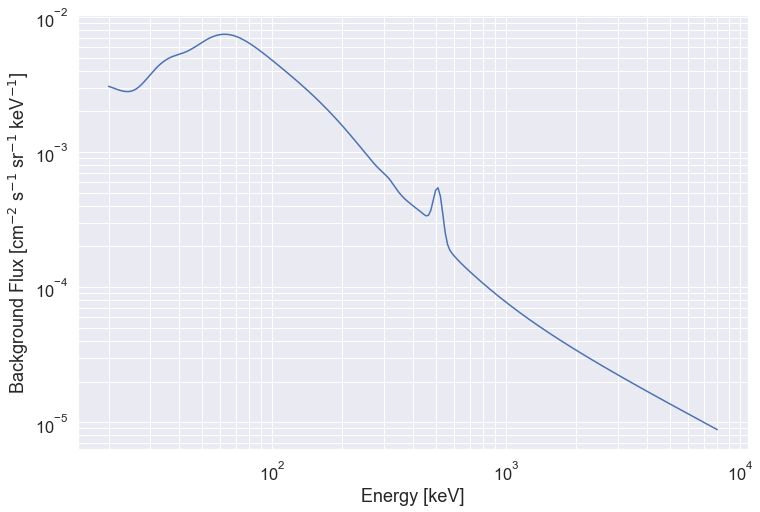

In [5]:

def bg_model_mm_v4(energylist, alt):
    """
    ;+  return a background x-ray model
    ;
    ; INPUT: energylist is a list of energies (keV)
    ;        alt is altitude in km (25<alt<40)
    ;
    ; OUTPUT: returns a list of counts/s/kev corresponding to energylist
    ;         returns -1 for input energy < 20keV
    ;
    ; METHOD: based on an empirical model derived from BARREL flights
    ;         model is ok between 20 and 8000 keV
    ;         background is primarily two power law components
    ;            these turn over at low energy
    ;            features at 26, 36, 312, 446, and 511 keV included
    ;         prevent underflows by avoiding exp(-huge number)
    ;
    ; CALLS: none
    ;
    ; EXAMPLE: result = brl_makebkgd([20,50,100,200],33.2)
    ;            calculates bkgd differential count rate at the
    ;            4 specified energies for a detector at 33.2 km alt.
    ;
    ; FUTURE WORK:
    ;
    ;COMMENT
    ; model ignores solar cycle changes of cosmic ray and associated background X-ray intensity
    ; the estimation for < 60keV is to some extent affected by detector temperature effect.
    ; REVISION HISTORY:
    ; works, tested mm/18 Dec 2012
    ; version 2, updated LZ/ May 28th, 2013 .
    ;- better constants values and latitude function than previous version
    ; version 4, updated LZ/ Mar 2015.
    ;- better constants values, more small features modelled
    ;- no longer uses mag latitude, since this effect was small
    ;- used data from second campaign to improve model
    # rewritten in Python, converted GB/ Jul 2023
    """
    if np.min(energylist) < 5: 
        return -1
    
    if alt < 25 or alt > 40:
        return -1
    
    altfactor = np.exp(-alt/8.5)
    
    S = len(energylist)

    c1 = 4.660e7*(altfactor + 0.03091)
    c2 = 340.8*(altfactor + 0.05344)
    c3 = 3.789*(altfactor + 0.03685)
    c4 = 565.5 - 8.648*alt
    c5 = 15.95 - 0.1489*alt

    powerlaw1 = c1*(energylist)**(-2.75)
    powerlaw2 = c2*(energylist)**(-0.92)

    turnover1 = np.zeros([S,])+1.
    good = np.where(energylist < 450)[0]
    if good.size > 0:
        turnover1[good] += c4*np.exp(-energylist[good]/9.39)

    turnover2 = np.zeros([S,])+1.
    good = np.where(energylist < 2000)[0]
    if good.size > 0:
        turnover2[good] += c5*np.exp(-energylist[good]/45.5)

    area26=np.zeros([S,])
    good = np.where(energylist < 60)[0]
    if good.size > 0:
        area26[good] = -0.32*np.exp(-((energylist[good]-25.6)/3.55)**2/2)

    area36=np.zeros([S,])
    good = np.where(energylist < 85)[0]
    if good.size > 0:
        area36[good] = 0.55*np.exp(-((energylist[good]-35.5)/5.1)**2/2)

    area312=np.zeros([S,])
    good = np.where((100 < energylist) & (energylist < 500))[0]
    if good.size > 0:
        area312[good] = 0.13*np.exp(-((energylist[good]-312)/20.)**2/2)

    area446=np.zeros([S,])
    good = np.where(energylist < 1000)[0]
    if good.size > 0:
        area446[good] = 0.18*np.exp(-((energylist[good]-445.47)/60.)**2/2)

    area511=np.zeros([S,])
    good = np.where((300 < energylist) & (energylist < 700))[0]
    if good.size > 0:
        area511[good] = np.exp(-((energylist[good]-511)/20.)**2/2)

    peaks = c3*(area511 + area446 + area312) + area36 + area26

    return (powerlaw1+powerlaw2)/(turnover1*turnover2) + peaks
    

E   = np.logspace(np.log10(20), np.log10(8000), 256) # keV , energy bin centers
G   = 716 # cm^2-sr , geometric factor
alt = 34  # km , balloon altitude

plt.figure(figsize=(12,8)); plt.grid(True, which='both')
plt.loglog(E, bg_model_mm_v4(E, alt)/G)

plt.xlabel('Energy [keV]')
plt.ylabel('Background Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
